In [61]:
#imports and helper functions
import GPy
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

def plot_hist(bins,bin_ranges,errs,alpha):
    """Plots a histogram"""
    assert len(bins)==(len(bin_ranges)-1)
    yvals = bins/(np.diff(bin_ranges)[:,None])
    evals = 1.96*errs/(np.diff(bin_ranges)[:,None]) #the error is in the area, which is 'spread'
    print(yvals)
    plt.bar(bin_ranges[0:-1],yvals[:,0],np.diff(bin_ranges),lw=1,alpha=alpha,color='#ccccff')
    midpoints = .5*(bin_ranges[0:-1] + bin_ranges[1:])
    plt.errorbar(midpoints,yvals,evals,elinewidth=1,capthick=1,color='black',alpha=alpha,lw=0)
    
def histogram_data(age,height,weight,age_step,height_step):
    inputs = []
    simple_inputs = []
    outputs = []
    for a in np.arange(1.5,8.5,age_step):
        for h in np.arange(70,125,height_step):
            weights = weight[ (age>=a) & (age<a+age_step) & (height>=h) & (height < h+height_step) ]
            if len(weights)>0:
                inputs.append([a,a+age_step,h,h+height_step])
                simple_inputs.append([a+(age_step/2.0),h+(height_step/2.0)])
                outputs.append(np.mean(weights))
    inputs = np.array(inputs)
    simple_inputs = np.array(simple_inputs)

    original_outputs = np.array(outputs)
    return inputs,simple_inputs,original_outputs

# Integral Kernel

I've called the kernel the 'integral kernel' as we use it when we know observations of the integrals of a function, and want to estimate the function itself.

Examples include:

- Knowing how far a robot has travelled after 2, 4, 6 and 8 seconds, but wanting an estimate of its speed after 5 seconds (use the `Integral` kernel)
- Wanting to know an estimate of the density of people aged 23, when we only have the total count for binned age ranges (use the `Integral_Limits` kernel)
- Wanting to estimate the weight distribution from a set of child, for a child of 5 years, with a height of 90cm, given data binned into a 3d table (using the `Multidimensional_Integral_Limits` kernel).

It should be noted that all three examples can be solved with the `Multidimensional_Integral_Limits` kernel. It might be worth, in the future, removing the other two kernels, to simplify the codebase.

## Speed of robot

This is the most simple example. For this example we use the `Integral` kernel.

We don't know this, but the robot is accelerating at a constant $\mathtt{1\; ms}^{-2}$, from stationary at $t=0$. We do know that after two seconds it had travelled two metres, after four seconds it had travelled eight metres, and after six and eight seconds it had travelled 18 and 32 metres respectively. The questions is: How fast was it going after five seconds?

In [68]:
#the observations
times   =   np.array([2.0,4.0, 6.0, 8.0])[:,None]
distances = np.array([2.0,8.0,18.0,32.0])[:,None]

#model configuration
kernel = GPy.kern.Integral(input_dim=1,variances=10.0)
m = GPy.models.GPRegression(times,distances,kernel)
m.optimize()
#m.plot_f()

#prediction for after five seconds
(speed, var) = m.predict_noiseless(np.array([[5.0]]))
print("After 5 seconds the robot was travelling at %0.2f m/s" % speed);

After 5 seconds the robot was travelling at 5.00 m/s


## Ages of people living in Kelham island: Probability density of being 23

In this example we are given some binned histogram data: We know that between the ages of zero and ten there are 19 children, between 11 and 20 there are 52, etc.

[[ 10   0]
 [ 20  10]
 [ 30  20]
 [ 40  30]
 [ 60  40]
 [100  60]]
[[  1.9]
 [  5.2]
 [ 11.4]
 [  4.5]
 [  1.1]
 [  0.5]]


(0, 15)

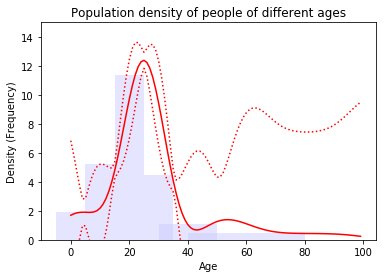

In [70]:
import numpy as np
bins = np.array([19,52,114,45,22,20])[None,:]
bin_ranges = np.array([0,10,20,30,40,60,100])

#The domain of each bin is set by pairs of values in the first two dimensions (see output).
#These could overlap!
X=np.vstack([bin_ranges[1:],bin_ranges[0:-1]]).T
print(X)
Y = bins.T

kernel = GPy.kern.Integral_Limits(input_dim=2, variances=0.1, lengthscale=10.0)
m = GPy.models.GPRegression(X,Y,kernel)
m.Gaussian_noise=0.001
m.optimize()

Xtest = np.arange(0,100,1.0) #for plotting
Xpred = np.array([Xtest,np.zeros(len(Xtest))])
Ypred,YpredCov = m.predict_noiseless(Xpred.T)
SE = np.sqrt(YpredCov)

plot_hist(bins.T,bin_ranges,0,alpha=0.5)
plt.plot(Xtest,Ypred,'r-',label='Mean')
plt.plot(Xtest,Ypred+SE*1.96,'r:',label='95% CI')
plt.plot(Xtest,Ypred-SE*1.96,'r:')
plt.title('Population density of people of different ages')
plt.xlabel('Age')
plt.ylabel('Density (Frequency)')
plt.ylim([0,15])

## Predicted range of weights of a child

I'm quickly generating some example data to illustrate the integral kernel over multiple dimensions.

In [126]:
#generate 100 simulated children heights, weights and ages.
Nchildren = 100
ages = np.random.random(Nchildren)*3.0+3.0 #ages 3 to 6
heights = 70 + ages * 7.0
weights = 9.0 + (heights-70)*0.2
weights += np.random.normal(0,0.3,weights.shape)
heights += np.random.normal(0,3,weights.shape)
ages += np.random.normal(0,0.3,weights.shape)

#group into a histogram (this is often the sort of data we'll actually have)
spacing_age = 1.0
spacing_height = 5.0
area = spacing_age * spacing_height
inputs, simple_inputs, outputs = histogram_data(ages,heights,weights,spacing_age,spacing_height)

In [127]:
print("            Age Range   Height Range   Average Weight (rounded)")
np.hstack([inputs,0.1*np.round(10*outputs[:,None])])

            Age Range   Height Range   Average Weight (rounded)


array([[   2.5,    3.5,   85. ,   90. ,   13.7],
       [   2.5,    3.5,   90. ,   95. ,   13.6],
       [   2.5,    3.5,   95. ,  100. ,   13.6],
       [   3.5,    4.5,   90. ,   95. ,   13.8],
       [   3.5,    4.5,   95. ,  100. ,   14.3],
       [   3.5,    4.5,  100. ,  105. ,   15.4],
       [   4.5,    5.5,   95. ,  100. ,   15.4],
       [   4.5,    5.5,  100. ,  105. ,   15.7],
       [   4.5,    5.5,  105. ,  110. ,   16.3],
       [   4.5,    5.5,  110. ,  115. ,   16.8],
       [   5.5,    6.5,  100. ,  105. ,   16.5],
       [   5.5,    6.5,  105. ,  110. ,   16.6],
       [   5.5,    6.5,  110. ,  115. ,   17.2],
       [   5.5,    6.5,  115. ,  120. ,   17.4]])

We want to predict their weight (say) from their height.

In [128]:
outputmean = np.mean(outputs)
outputs -= outputmean

In [129]:
#we have twice as many dimensions as the actual data as each
#pair of dimensions is used to specify one dimension in the domain of each bin.
#the input matrix above is used, so dimension 0 and 1 specify the start
#and end of each bin in the 'age' direction. etc...
kernel = GPy.kern.Multidimensional_Integral_Limits(input_dim=4, variances=1.0, lengthscale=[8.0,4.0])
m = GPy.models.GPRegression(1.0*inputs,1.0*area*outputs[:,None],kernel)
m.optimize()

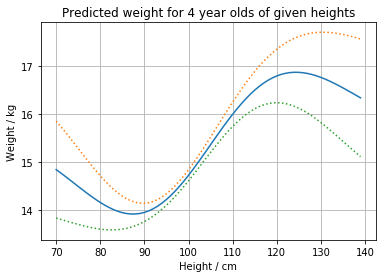

In [130]:

a = 4.0
Xpred = []
test_heights = range(70,140)
for h in test_heights:
    Xpred.append([a,0,h,0])
Xpred = np.array(Xpred)
weight, err = m.predict_noiseless(Xpred)
plt.plot(test_heights,weight+outputmean)
plt.plot(test_heights,weight+outputmean+np.sqrt(err),':')
plt.plot(test_heights,weight+outputmean-np.sqrt(err),':')
plt.xlabel('Height / cm')
plt.ylabel('Weight / kg')
plt.grid()
plt.title('Predicted weight for 4 year olds of given heights');

The above curve is based on the histogram 'binned' data.